# 多类别分类和神经网络
在本练习中，你将实现一对多逻辑回归和使用神经网络来识别手写数字。

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io # 用来载入 OCTAVE *.mat 文件
import matplotlib.cm as cm # 用于在特定颜色映射中显示图像
import random # 为了随机选择图片显示
from scipy.special import expit # 向量化的sigmod函数
from PIL import Image # 用于图片处理

### 1. 多类别分类
在本练习中，你将使用逻辑回归和神经网络来识别手写数字（从0到9）。   
如今，自动手写数字识别被广泛使用 - 从识别邮件信封上的邮政编码（邮政编码）到识别银行支票上的金额。  
本练习将向你展示你学习的方法如何用于此分类任务。 在练习的第一部分中，你将扩展先前的逻辑回归实现并将其应用于一对一分类
#### 1.1 数据集
* 你将在ex3data1.mat中获得一个数据集，其中包含5000个手写数字的训练示例。  
  .mat格式表示数据已保存为原生Octave / MATLAB矩阵格式，而不是像文本（ASCII）格式一样一个csv文件。  
 可以使用load命令将这些矩阵直接读入程序。加载后，正确尺寸和值的矩阵将出现在程序的内存中。矩阵已经命名，因此无需为其指定名称。  
* ex3data1.mat中有5000个训练示例，其中每个训练示例是数字的20像素乘20像素灰度图像。   
  每个像素由浮点数表示，该浮点数表示该位置处的灰度强度。 20×20像素网格被“展开”成400维向量。   
  这些训练样例中的每一个在我们的数据矩阵X中变成单行。这给出了5000乘400矩阵X，其中每行是手写数字图像的训练示例。  
  $$ X = 
  \begin{bmatrix} 
  - (x^{(1)})^T -\\
  - (x^{(2)})^T -\\
  ...\\
  - (x^{(m)})^T - 
  \end{bmatrix} \quad $$
* 训练集的第二部分是5000维向量y，包含训练集的标签。 为了兼容Octave / MATLAB索引，没有零索引。   
  因此，手写数字“0”标记为“10”，而数字“1”到“9”按其自然顺序标记为“1”到“9”。

In [48]:
datafile = 'ex3data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
X = np.insert(X,0,1,axis=1) # 照常给矩阵X插入一列“1”
print ("'y' shape: %s. Unique elements in y: %s" %(mat['y'].shape,np.unique(mat['y'])))
print ("'X' shape: %s. X[0] shape: %s" %(X.shape,X[0].shape))
#X 是 5000 个图片. 每个图片是一行. 每个图片有400像素(20x20)
#y 是每个图片的类别. 1-10, 10代表手写数字“0”

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


#### 1.2 数据可视化
从.mat文件导入的数据范围在0~1左右，最大值为1.12，最小值为-0.13。  
原作者使用的是scipy.misc.toimage()在新版中已经不可用，改用了PIL.Image.fromarray()。  
而PIL支持的8位灰度图像要求0~255，所以将数据乘以255才可以正常显示出图像

In [91]:
def getDatumImg(row):
    """
    从X矩阵获取1x400的一行数组，转化成20x20的图片数组并返回
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    从X矩阵随机获取100行，从每行创建出一个20x20的图片，然后把它们拼接成10x10网格的图像并显示
    """
    width, height = 20, 20 # 每个小图片的宽，高
    nrows, ncols = 10, 10  # 小图片行数列数
    
    # 如果没有指定要显示的图像，就随机从X矩阵中选择 nrows*ncols 个图像进行显示
    if not indices_to_display: 
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)  # indices_to_display 是随机从X矩阵中选择的行数
         
    big_picture = np.zeros((height*nrows,width*ncols))
    
    # 对于每一行，插入10个小图，然后切换到下一行，直到完成第10行
    irow, icol = 0, 0 # 正在添加的小图片的行数和列数
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[ irow*height: irow*height+iimg.shape[0], icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
        
    big_picture *= 255     # Imag.fromarray不适用原数据，无法显示，转化一下
    img = Image.fromarray(big_picture)
    
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap="gray")

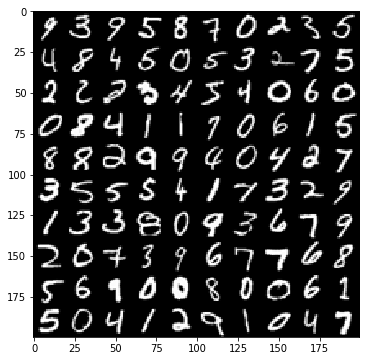

In [98]:
displayData()

#### 1.3 向量化的逻辑回归
你将使用多个一对多逻辑回归模型来构建多类分类器。  
由于有10个类，所以需要训练10个单独的逻辑回归分类器。为了使这种培训更有效，确保代码很好地进行矢量化非常重要。  
在本节中，将实现逻辑回归的矢量化版本，该版本不使用任何for循环。
##### 1.3.1 向量化的代价函数
我们将从编写成本函数的矢量化版本开始。回想一下，在（非正则化）逻辑回归中，成本函数是:$$J（θ）= \frac{1}{m}\sum\limits_{i=1}^n[ -y^{(i)}log(h_θ(x^{(i)}))- (1 - y^{(i)})log( 1 - h_θ(x^{(i)}))]$$
为了计算求和中的每个元素，我们必须计算每个例子i的 $h_θ(x^{(i)})$，其中 $h_θ(x^{(i)})= g(θ^Tx^{(i)})$ 和 $g(z)=\frac{1}{1 + e^{-z}}$ 是4个sigmoid函数。事实证明，我们可以通过使用矩阵乘法快速计算所有示例。让我们将X和θ定义为  
$X = 
\begin{bmatrix} 
- (x^{(1)})^T -\\
- (x^{(2)})^T -\\
...\\
- (x^{(m)})^T - 
\end{bmatrix} \quad$ 和 
$θ = 
\begin{bmatrix} 
θ_0 \\
θ_1\\
...\\
θ_m 
\end{bmatrix}$。  

然后，通过计算矩阵乘积Xθ，我们得到
$$ Xθ = 
\begin{bmatrix} 
- (x^{(1)})^Tθ -\\
- (x^{(2)})^Tθ -\\
...\\
- (x^{(m)})^Tθ - 
\end{bmatrix} =
\begin{bmatrix} 
- θ^T(x^{(1)}) -\\
- θ^T(x^{(2)}) -\\
...\\
- θ^T(x^{(m)}) - 
\end{bmatrix}$$
在最后的等式中，我们使用了如果a和b是向量，则a^Tb = b^Ta的事实。这允许我们在一行代码中计算所有示例i的乘积θ^Tx^{(i)}。您的工作是在文件lrCostFunction.m中编写未经规范的成本函数。您的实现应使用我们上面提出的策略来计算θ^Tx^{(i)}。您还应该使用矢量化方法来完成剩余的成本函数。 lrCostFunction.m的完全矢量化版本不应包含任何循环。 （提示：您可能希望在编写此函数时使用逐元素乘法运算（.*）和求和运算和）

In [41]:
# 假设函数
def h(mytheta,myX):
    return expit(np.dot(myX,mytheta))

# 简化的代价函数写法
def computeCost(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0] #5000
    myh = h(mytheta,myX) #shape: (5000,1)
    term1 = np.log( myh ).dot( -myy.T ) #shape: (5000,5000)
    term2 = np.log( 1.0 - myh ).dot( 1 - myy.T ) #shape: (5000,5000)
    left_hand = (term1 - term2) / m #shape: (5000,5000)
    right_hand = mytheta.T.dot( mytheta ) * mylambda / (2*m) #shape: (1,1)
    return left_hand + right_hand #shape: (5000,5000)

#### 1.4 一对多分类
OCTAVE 'fmincg'的替代品，我们将使用一些scipy.optimize函数，“fmin_cg” 这对于大量参数更有效。  
在之前的作业中，没有必要计算成本梯度，因为 scipy.optimize的函数通过某种插值实现了。  
但是，fmin_cg需要递交的渐变，所以这里将会实现  

In [42]:
def costGradient(mytheta,myX,myy,mylambda = 0.):
    m = myX.shape[0]
    #Tranpose y here because it makes the units work out in dot products later
    #(with the way I've written them, anyway)
    beta = h(mytheta,myX)-myy.T #shape: (5000,5000)

    #regularization skips the first element in theta
    regterm = mytheta[1:]*(mylambda/m) #shape: (400,1)

    grad = (1./m)*np.dot(myX.T,beta) #shape: (401, 5000)
    #regularization skips the first element in theta
    grad[1:] = grad[1:] + regterm
    return grad #shape: (401, 5000)

In [43]:
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    result = optimize.fmin_cg(computeCost, fprime=costGradient, x0=mytheta, \
                              args=(myX, myy, mylambda), maxiter=50, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [97]:
X.max()

1.127688299158888